In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
val_ds = test_ds.skip(test_size // 2)
test_ds = test_ds.take(test_size // 2)

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])


In [7]:
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

vgg_model = tf.keras.applications.VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
                                        include_top=False,
                                        weights='imagenet')

for layer in vgg_model.layers:
    layer.trainable = False

model = models.Sequential([
    vgg_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
54/54 [==============================] - 143s 3s/step - loss: 1.9528 - accuracy: 0.4419 - val_loss: 0.9043 - val_accuracy: 0.4688
Epoch 2/50
54/54 [==============================] - 147s 3s/step - loss: 0.9296 - accuracy: 0.4671 - val_loss: 0.8907 - val_accuracy: 0.4531
Epoch 3/50
54/54 [==============================] - 146s 3s/step - loss: 0.9465 - accuracy: 0.4566 - val_loss: 0.8343 - val_accuracy: 0.4583
Epoch 4/50
54/54 [==============================] - 146s 3s/step - loss: 0.9235 - accuracy: 0.5035 - val_loss: 0.8717 - val_accuracy: 0.4740
Epoch 5/50
54/54 [==============================] - 155s 3s/step - loss: 0.9409 - accuracy: 0.4676 - val_loss: 0.9549 - val_accuracy: 0.4323
Epoch 6/50
54/54 [==============================] - 154s 3s/step - loss: 0.9194 - accuracy: 0.4589 - val_loss: 0.9457 - val_accuracy: 0.5052
Epoch 7/50
54/54 [==============================] - 143s 3s/step - loss: 0.9278 - accuracy: 0.4507 - val_loss: 0.9995 - val_accuracy: 0.4323
Epoch 8/50
54

In [8]:
scores = model.evaluate(test_ds)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

8/8 [==============================] - 16s 2s/step - loss: 0.9152 - accuracy: 0.4181
Test loss: 0.9151554703712463
Test accuracy: 0.4181034564971924


8/8 [==============================] - 18s 2s/step


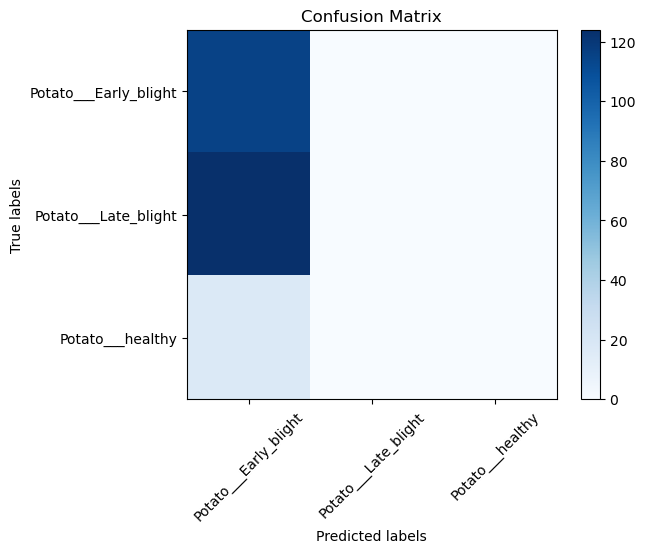

In [11]:
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)

plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.title('Confusion Matrix')
plt.show()

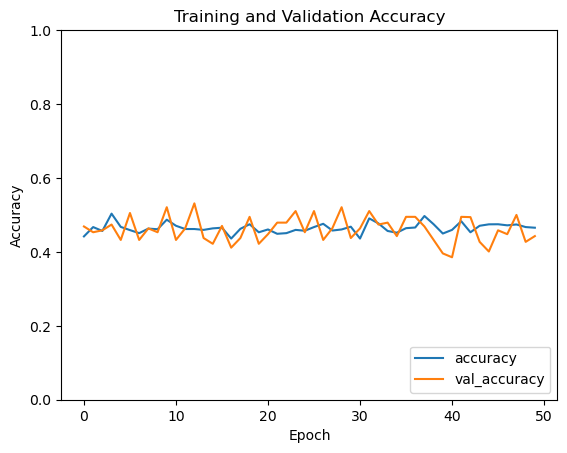

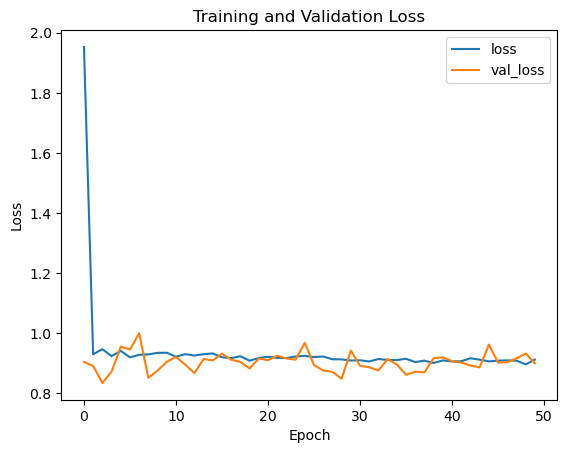

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
